# Find patterns by site in heatmap
In this notebook the following tasks will be accomplished:

1. Create arrays for heatmap, one per meter-site.
2. Find patterns in those arrays.
    - *Type A error - System-wise operational non routine event*: high errors in a date in most of the buildings in site (number of buildings > `t_bdg`).
    - *Type B error - Major consistent operational change*: high error in a single building during most of the time period.
    - *Type C error - Medium-term, single building operational non-routine event*: high errors in a single building, during periods longer than `t_dates`.
    - *Type D error - Short-term, single building non-routine event*: high errors in a single building, during periods shorter than days_threshold.
    - *Type E error (special case of type D errors) - Fluctuating medium and long term error*: high non-consecutive errors in a single building.

In [1]:
import glob

# Data and numbers
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.preprocessing import MinMaxScaler

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
%matplotlib inline

In [2]:
path_data = "..\\data\\processed\\summary\\"
path_leak = "..\\data\\leaked\\"
path_meta = "..\\data\\original\\metadata\\"
path_arrays = "..\\data\\processed\\arrays\\"
path_res = "..\\results\\"

# Functions

In [3]:
def heatmaps_comp(df,df_bool):

    """This function plots two heatmaps side by side:
        - The original heatmap\n
        - A heatmap where only values over ´tresh_error´ are colored\n

        df: original values for a meter-site.
        df_bool: masked df for that meter-site, where only values over `tresh_error` are 1 (otherwise, 0)\n
    """
    
    fig, axes = plt.subplots(1, 2, sharex = True, sharey=True, figsize=(16,8))
    axes = axes.flatten()

    # Get the data
    y = np.linspace(0, len(df), len(df)+1)
    x = pd.date_range(start='2017-01-01', end='2018-12-31')
    cmap = plt.get_cmap('YlOrRd')

    for i,data in enumerate([df_bool,df]):
        
        # Plot
        ax = axes[i]
        data = data
        qmesh = ax.pcolormesh(x, y, data, cmap=cmap, rasterized=True, vmin=0, vmax=1)

        # Axis
        plt.locator_params(axis='y', nbins=len(list(data.index)) + 1)
        ax.axis('tight') 
        ax.xaxis_date() # Set up as dates
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%y')) # set date's format
        ax.set_yticklabels(list(df_bool.index)) # omit building ID on y axis

    # Color bar  
    cbar = fig.colorbar(qmesh, ax=ax)
    cbar.set_label('Min-Max scaled RMSLE')

    fig.suptitle(f"{meter} - site {site}", y = 1.015, fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    #plt.pcolormesh(df, cmap='YlOrRd', rasterized=True)

    return fig

In [4]:
def error_A(file, meter, t_error, t_bdg, error_type): 
    """
    Calculates errors type A in file.

    file: path to meter-site normalizes RMSLE array (building_id vs. date).\n
    t_error: threshold for RMSLE value.\n
    t_bdg: threshold for the proportion of buildings with high error values in a date to consider it a type A error.\n

    returns:
        - Site ID.\n
        - A sparse dataframe, with `error_type` in those buildings-dates an error ocurs.\n
        - A sparse dataframe, with 1 on those values over `t_error`.\n
    """
    # Site id
    site = file.split("\\")[-1].split("_")[-1].split(".")[0]
    print(f"{meter} - site {site}")

    # Load data
    df = pd.read_csv(file).set_index("building_id")
    # Color only error greater than treshold
    df_bool = (df > t_error).astype(int)
    # Create empty df to assign errors
    df_empty = df[df<0]

    # Sum values for each date
    by_date = pd.DataFrame(df_bool.sum()).reset_index().rename(columns={"index":"date",0:"sum_val"})
    # Filter dates that has high error in more than t_bdg% of buildings
    results = by_date[by_date.sum_val > t_bdg*len(df_bool.index)]
    # error_type those dates in df_empty
    df_empty.loc[:,list(results.date)] = df_bool.loc[:,list(results.date)]
    #  Replace with error type name
    df_empty.replace([0,1],[np.nan,error_type], inplace=True)

    return site, df_empty, df_bool

In [16]:
def error_B(file, meter, t_error, t_prop, error_type, remove_errors, path_errors): 
    """
    Calculates errors type B in file.

    file: path to meter-site normalizes RMSLE array (building_id vs. date).\n
    t_error: threshold for RMSLE value.\n
    t_bdg: proportion of high error during total period, to consider it a Type D error.\n
    remove_errors: wether if remove type A errors before calculating type B.\n

    returns:
        - Site ID.\n
        - A sparse dataframe, with `error_type` in those buildings-dates an error ocurs.\n
        - A sparse dataframe, with 1 on those values over `t_error`.\n
    """
    # Site id
    site = file.split("\\")[-1].split("_")[-1].split(".")[0]
    print(f"{meter} - site {site}")

    # Load file
    df = pd.read_csv(file,index_col="building_id")
    # Keep only error greater than treshold
    df_bool = (df > t_error).astype(int)

    if remove_errors==True: # Remove type A errors
        
        # Load erros
        df_A = pd.read_csv(path_errors + f"{meter}_site_{site}_errorA.csv").set_index("building_id")
        # Replace on current df
        df_bool.update(df_A)
        # Remove them
        df_bool.replace("A",0, inplace=True)

    else:
        pass

    # Find errors
    dfs = []
    df_bdg = df_bool.T

    for col in df_bdg.columns:
        # Select one building
        df1 = df_bdg[[col]]
        # Calculate proportion of error in whole period
        p = df1[col].sum() / len(df1)
        # Mark when there is major error (i.e, proportion of high error greater than threshold)
        if p > t_prop:
            df1["mark"] = df1[col]
        else:
            df1["mark"] = 0

        # Rename
        df1 = df1[["mark"]].rename(columns={"mark":col})
        df1 = df1.replace([1,0],[error_type,np.nan])
        # Append
        dfs.append(df1)

    # Create errors df
    df_B = pd.concat(dfs, axis=1)
    df_B = df_B.T

    return site, df_B, df_bool

In [6]:
def error_C(file, meter, t_error, t_dates, error_type, remove_errors, path_errors): 
    """
    Calculates errors type C in file.

    file: path to meter-site normalizes RMSLE array (building_id vs. date).\n
    t_error: threshold for RMSLE value.\n
    t_dates: number of minimum consecutive days to consider ir a type D error.\n
    remove_errors: wether if remove type A and B errors before calculating type C.\n

    returns:
        - Site ID.\n
        - A sparse dataframe, with `error_type` in those buildings-dates an error ocurs.\n
        - A sparse dataframe, with 1 on those values over `t_error`.\n
    """
    # Site id
    site = file.split("\\")[-1].split("_")[-1].split(".")[0]
    print(f"{meter} - site {site}")

    # Load file
    df = pd.read_csv(file,index_col="building_id")
    # Keep only error greater than treshold
    df_bool = (df > t_error).astype(int)
    # Create empty df to assign errors
    df_empty = df[df<0]

    if remove_errors==True: # Remove type A amd B errors
        
        # Load errors type A
        df_A = pd.read_csv(path_errors + f"{meter}_site_{site}_errorA.csv").set_index("building_id")
        # Replace on current df
        df_bool.update(df_A)
        # Remove them
        df_bool.replace("A",0, inplace=True)

        # Load errors type B
        df_B = pd.read_csv(path_errors + f"{meter}_site_{site}_errorB.csv").set_index("building_id")
        # Replace on current df
        df_bool.update(df_B)
        # Remove them
        df_bool.replace("B",0, inplace=True)

    else:
        pass 

    ### GET HIGH ERRORS BY BDG ###
    dfs = []
    df_bdg = df_bool.T

    for col in df_bdg.columns:
        # Select one building
        df1 = df_bdg[[col]]
        # Tag groups of consequtive equal numbers
        df1['grp'] = (df1[col] != df1[col].shift()).cumsum()
        # Filter values == 1 (error higher than t_error)
        df1 = df1.loc[df1[col] == 1,].reset_index().rename(columns={"index":"date"}, index={"building_id":"index"})[["date","grp"]]
        # Add bdg number
        df1["building_id"] = col
        # Get buildings with high error during period longer than t_dates
        by_group = df1[["date","grp"]].groupby("grp").count().reset_index() # group
        groups = list(by_group.loc[by_group.date > t_dates, "grp"]) # get list of groups
        mt = df1[df1.grp.isin(groups) == True] # filter and get only those groups
        mt["error"] = error_type
        # Append to list
        dfs.append(mt)

    # Concat all
    df2 = pd.concat(dfs)
    # Pivot
    df2 = df2.pivot(index="date",columns="building_id", values="error").T
    # Replace on df_empty
    df_empty.update(df2)

    return site, df_empty, df_bool

In [7]:
def error_D(file, meter, t_error, t_dates, error_type, remove_errors, path_errors): 
    """
    Calculates errors type D in file.

    file: path to meter-site normalizes RMSLE array (building_id vs. date).\n
    t_error: threshold for RMSLE value.\n
    t_dates: number of maximum consecutive days to consider ir a type D error.\n
    remove_errors: wether if remove type A and B errors before calculating type C.\n

    returns:
        - Site ID.\n
        - A sparse dataframe, with `error_type` in those buildings-dates an error ocurs.\n
        - A sparse dataframe, with 1 on those values over `t_error`.\n
    """
    # Site id
    site = file.split("\\")[-1].split("_")[-1].split(".")[0]
    print(f"{meter} - site {site}")

    # Load file
    df = pd.read_csv(file,index_col="building_id")
    # Keep only error greater than treshold
    df_bool = (df > t_error).astype(int)
    # Create empty df to assign errors
    df_empty = df[df<0]

    if remove_errors==True: # Remove type A amd B errors
        
        # Load errors type A
        df_A = pd.read_csv(path_errors + f"{meter}_site_{site}_errorA.csv").set_index("building_id")
        # Replace on current df
        df_bool.update(df_A)
        # Remove them
        df_bool.replace("A",0, inplace=True)

        # Load errors type B
        df_B = pd.read_csv(path_errors + f"{meter}_site_{site}_errorB.csv").set_index("building_id")
        # Replace on current df
        df_bool.update(df_B)
        # Remove them
        df_bool.replace("B",0, inplace=True)

    else:
        pass 
        
    ### GET HIGH ERRORS BY BDG ###
    dfs = []
    df_bdg = df_bool.T

    for col in df_bdg.columns:
        # Select one building
        df1 = df_bdg[[col]]
        # Tag groups of consequtive equal numbers
        df1['grp'] = (df1[col] != df1[col].shift()).cumsum()
        # Filter values == 1 (error higher than t_error)
        df1 = df1.loc[df1[col] == 1,].reset_index().rename(columns={"index":"date"}, index={"building_id":"index"})[["date","grp"]]
        # Add bdg number
        df1["building_id"] = col
        # Get buildings with high error during period shorter than tresh_dates (but greater than 0)
        by_group = df1[["date","grp"]].groupby("grp").count().reset_index() # group
        groups = list(by_group.loc[(by_group.date > 0) & (by_group.date <= t_dates), "grp"]) # get list of groups
        st = df1[df1.grp.isin(groups) == True] # filter and get only those groups
        st["error"] = error_type
        # Append to list
        dfs.append(st)

    # Concat all
    df2 = pd.concat(dfs)
    # Pivot
    df2 = df2.pivot(index="date",columns="building_id", values="error").T
    # Replace on df_empty
    df_empty.update(df2)

    return site, df_empty, df_bool

In [8]:
def error_E(d_file, meter, t_error, t_dates, error_type, remove_errors, path_errors): 
    """
    Calculates errors type E in file.

    file: path to meter-site type D error (building_id vs. date).\n
    w: time window to check error.\n
    t_w: proportion of error during time window.\n
    remove_errors: wether if remove type A and B errors before calculating type C.\n

    returns:
        - Site ID.\n
        - A sparse dataframe, with `error_type` in those buildings-dates an error ocurs.\n
        - A sparse dataframe, with 1 on those values over `t_error`.\n
    """
    # Site id
    site = file.split("\\")[-1].split("_")[2]
    print(f"{meter} - site {site}")

    # Load data
    df = pd.read_csv(file).set_index("building_id")
    # Color only error greater than treshold
    df_bool = df.replace("D",1)

    if remove_errors==True: # Remove type A amd B errors
        
        # Load errors type A
        df_A = pd.read_csv(path_errors + f"{meter}_site_{site}_errorA.csv").set_index("building_id")
        # Replace on current df
        df_bool.update(df_A)
        # Remove them
        df_bool.replace("A",0, inplace=True)

        # Load errors type B
        df_B = pd.read_csv(path_errors + f"{meter}_site_{site}_errorB.csv").set_index("building_id")
        # Replace on current df
        df_bool.update(df_B)
        # Remove them
        df_bool.replace("B",0, inplace=True)

    else:
        pass 
        
    # Find errors
    dfs = []
    df_bdg = df_bool.T

    ### CHECK IF t_w PROPORTION IS EXCEED DURIN w TIME PERIOD ###
    for col in df_bdg.columns:
        # Select one building
        df1 = df_bdg[[col]].reset_index().rename(columns={"index":'date'}).fillna(0)
        # Calculate rolling sum
        df1["rol_sum"] = df1[col].rolling(w).sum()
        # Get index of last row of windows, which sum is over threshold
        idx = df1[df1["rol_sum"] > w*t_w].index
        # Mark whole window
        if len(idx) > 0:
            for ix in list(idx):
                i0 = ix-w
                it = ix
                df1.loc[i0:it,"mark"] = df1.loc[i0:it,col] #copy original values in window
        else:
            df1["mark"] = np.nan
        # Rename and complete df
        df1 = df1.set_index("date").drop([col,"rol_sum"],axis=1).rename(columns={"mark":col})
        # Append
        dfs.append(df1)

    #Create errors df
    df_E = pd.concat(dfs,axis=1).replace([0,1],[np.nan,error_type]).T

    return site, df_E, df_bool

## Create arrays for heatmap

In [9]:
"""meters = ["electricity","chilledwater","hotwater","steam"]
group = "site_id"
metric = "RMSLE"

for meter in meters:

    # Load data
    df = pd.read_pickle(path_data + f"date_vs_bdg\\{meter}_RMSLE.pickle.gz")

    # Remove leaked buidings
    leak = pd.read_csv(path_leak + f"leak_{meter}.csv")
    df = df[df.building_id.isin(leak.building_id) == False]

    # Datetime object
    df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d")

    # Complete missing dates
    df = utils.complete_data(df,"2017-01-01","2018-12-31")

    # Merge with metadata
    meta_bdg = pd.read_csv(path_meta + "building_metadata.csv")
    df = pd.merge(df, meta_bdg, how="left", on="building_id")

    # Scale metric between 0 and 1
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_rmsle = scaler.fit_transform(np.array(df.rmsle).reshape(-1, 1))
    # Add to df
    df["rmsle_scaled"] = scaled_rmsle
    # Print limits
    print(f"Meter: {meter}")
    print(f"Min rmsle: {df.rmsle.min()}. Max rmsle: {df.rmsle.max()}")
    print(f"Min rmsle_scaled: {df.rmsle_scaled.min()}. Max rmsle_scaled: {df.rmsle_scaled.max()}")
    print("")

    # Create arrays
    group_name = list(df[group].unique())

    for i,j in enumerate(group_name):

        # Filter data
        df_grouped = df[df[group] == j]

        # Pivot data
        pivot_df = df_grouped.pivot(columns="timestamp", index="building_id", values="rmsle_scaled")

        # Sort in descending order (sum RMSLE)
        pivot_df["sum"] = np.sum(pivot_df,axis=1).tolist()
        pivot_df = pivot_df.sort_values("sum")
        pivot_df.drop("sum",axis=1, inplace=True)

        # Save df
        pivot_df.to_csv(path_arrays + f"{meter}_{metric}_site_{j}.csv")
        """

'meters = ["electricity","chilledwater","hotwater","steam"]\ngroup = "site_id"\nmetric = "RMSLE"\n\nfor meter in meters:\n\n    # Load data\n    df = pd.read_pickle(path_data + f"date_vs_bdg\\{meter}_RMSLE.pickle.gz")\n\n    # Remove leaked buidings\n    leak = pd.read_csv(path_leak + f"leak_{meter}.csv")\n    df = df[df.building_id.isin(leak.building_id) == False]\n\n    # Datetime object\n    df.timestamp = pd.to_datetime(df.timestamp, format="%Y-%m-%d")\n\n    # Complete missing dates\n    df = utils.complete_data(df,"2017-01-01","2018-12-31")\n\n    # Merge with metadata\n    meta_bdg = pd.read_csv(path_meta + "building_metadata.csv")\n    df = pd.merge(df, meta_bdg, how="left", on="building_id")\n\n    # Scale metric between 0 and 1\n    scaler = MinMaxScaler(feature_range=(0,1))\n    scaled_rmsle = scaler.fit_transform(np.array(df.rmsle).reshape(-1, 1))\n    # Add to df\n    df["rmsle_scaled"] = scaled_rmsle\n    # Print limits\n    print(f"Meter: {meter}")\n    print(f"Min rmsle

# Choose meter

In [10]:
meter = "steam"
files = glob.glob(path_arrays + f"{meter}*.csv")

# Compare figures

In [6]:
# Thresholds
t_error = 0.3 # error

# Dict to save number of errors
total_errors = {}

for file in files:    

    # Site id
    site = file.split("\\")[-1].split("_")[-1].split(".")[0]

    # Load data
    df = pd.read_csv(file).set_index("building_id")
    # Color only error greater than treshold
    df_bool = (df > t_error).astype(int)
    #fig = heatmaps_comp(df,df_bool)
    #fig.savefig(path_res + f"{meter}_site_{site}_comp.png", bbox_inches='tight', dpi=200)

    # Count errors and append to dict
    total_errors[site] = df_bool.sum().sum()

# Type A errors
*System-wise operational non routine event*: high errors in a date in most of the buildings in site (`t_bdg`)

steam - site 13
steam - site 14
steam - site 15
steam - site 6
steam - site 7
steam - site 9


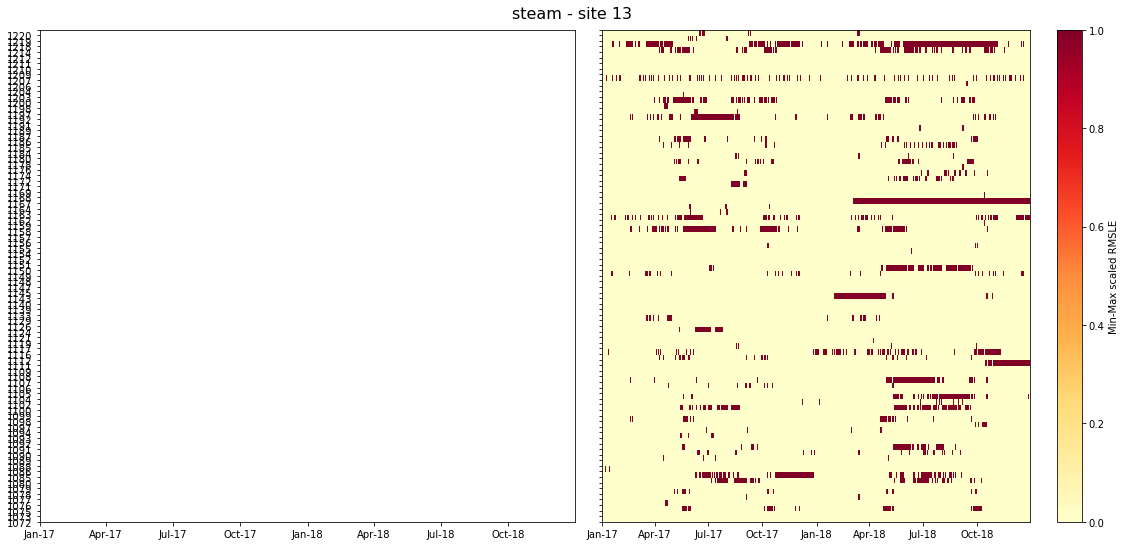

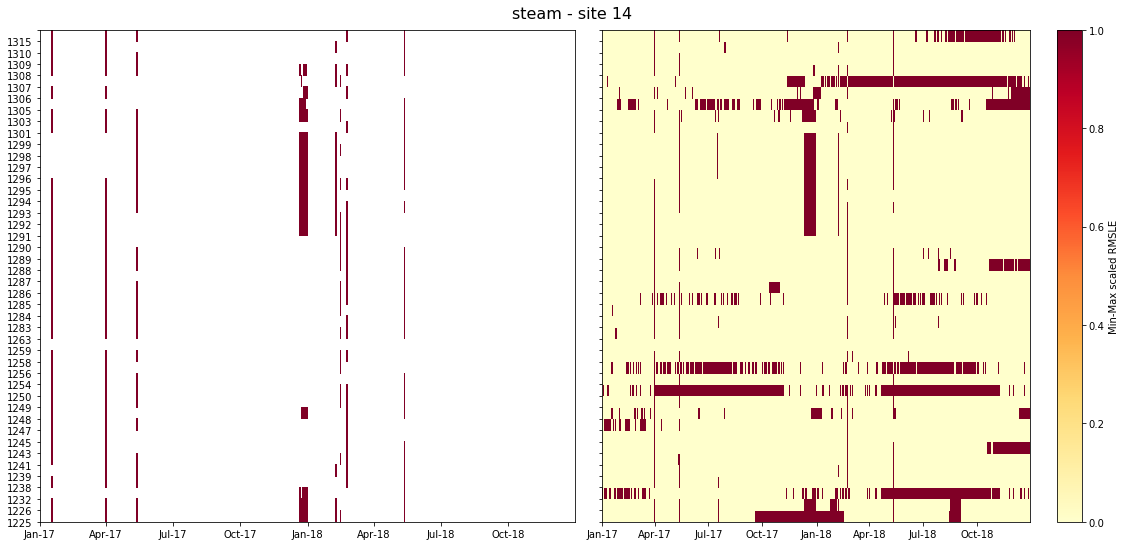

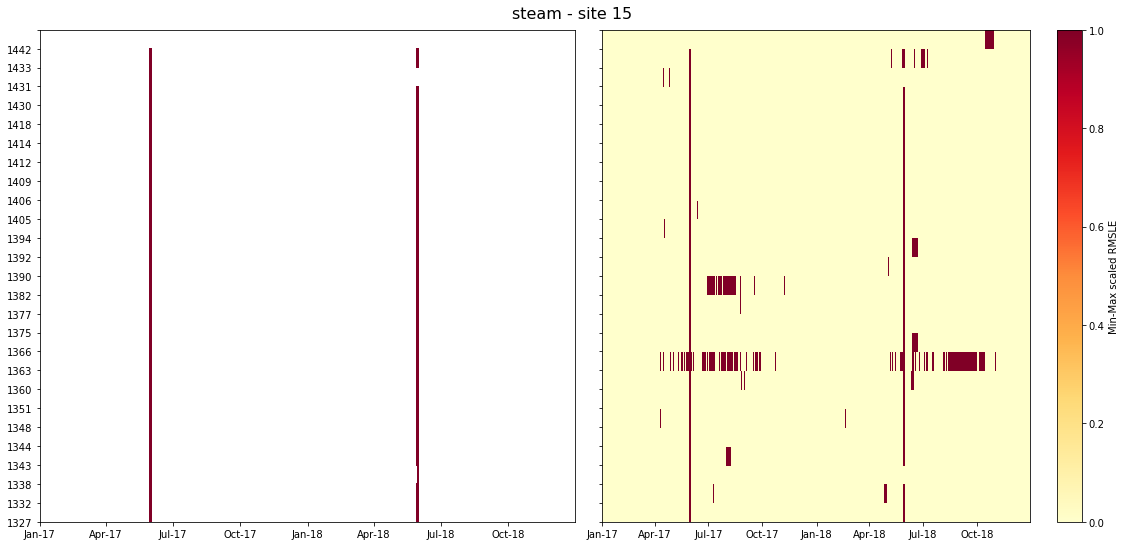

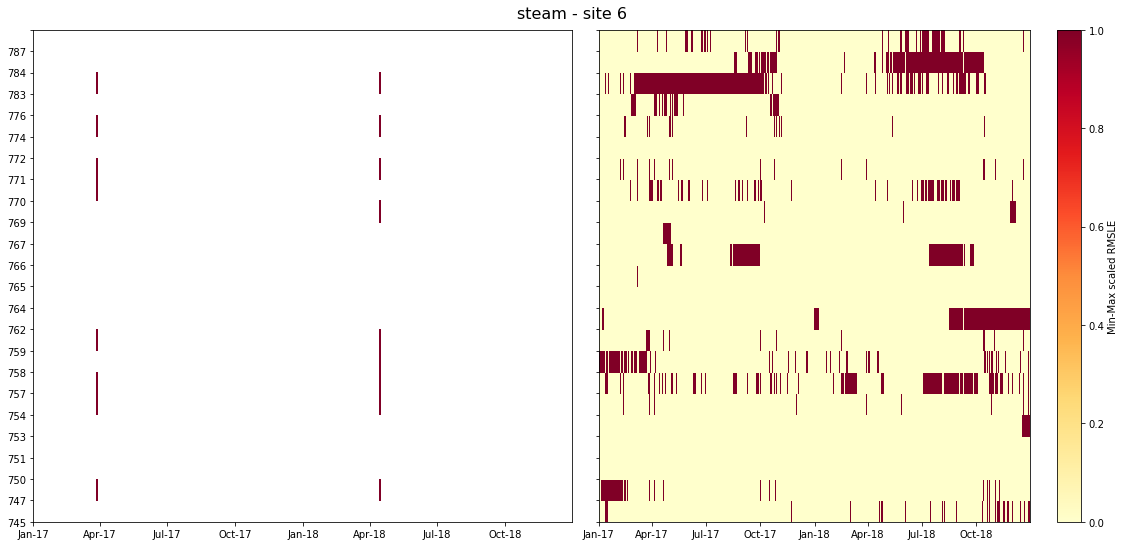

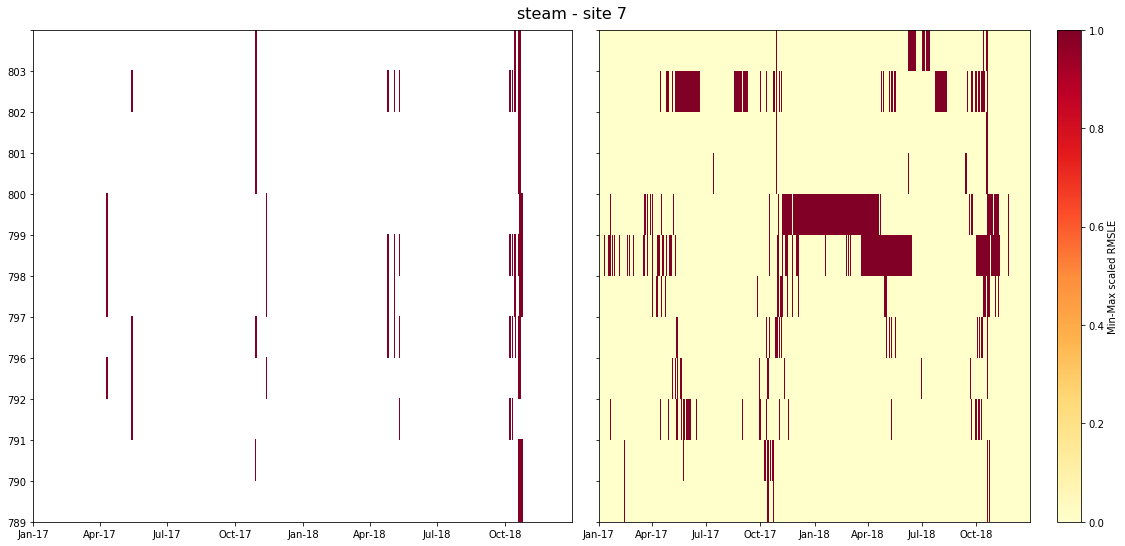

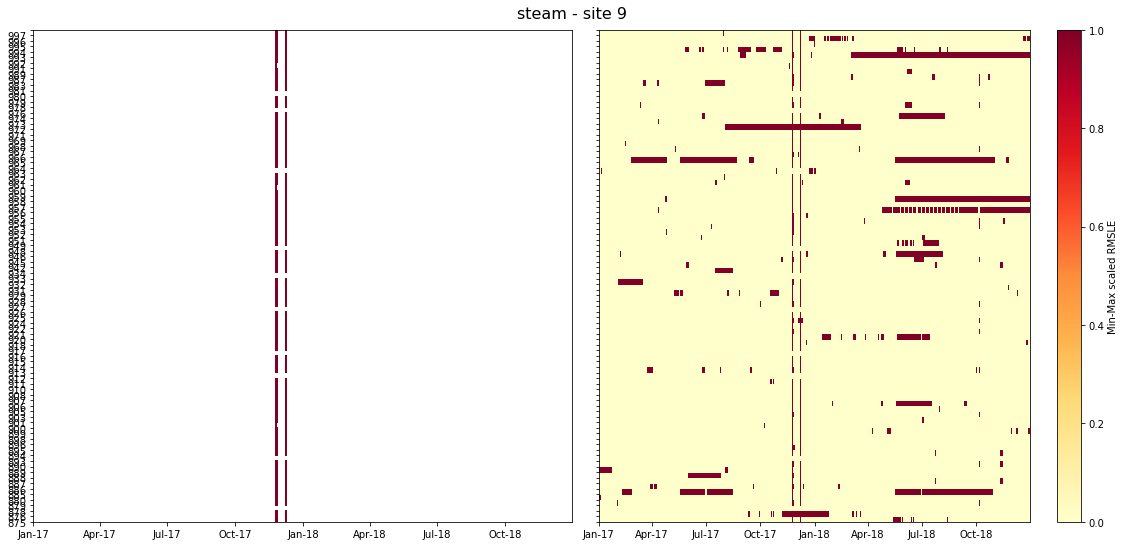

In [11]:
# Function parameters
t_error = 0.3
t_bdg = 0.33
error_type = "A"

# Dict to save number of errors
A_errors = {}

for file in files:
    # Create error df for the file
    site, df_A, df_bool = error_A(file, meter, t_error, t_bdg, error_type)

    # Save file
    #df_A.to_csv(path_res + f"{meter}_site_{site}_error{mark}.csv")

    # Count errors by site and append to dict
    A_errors[site] = df_A.T.notna().sum().sum() 

    # Plot
    fig = heatmaps_comp(df_bool,df_A.replace(error_type,1))

# Type B error
*Major consistent operational change*: high error in a single building during most of the time period.

steam - site 13
steam - site 14
steam - site 15
steam - site 6
steam - site 7
steam - site 9


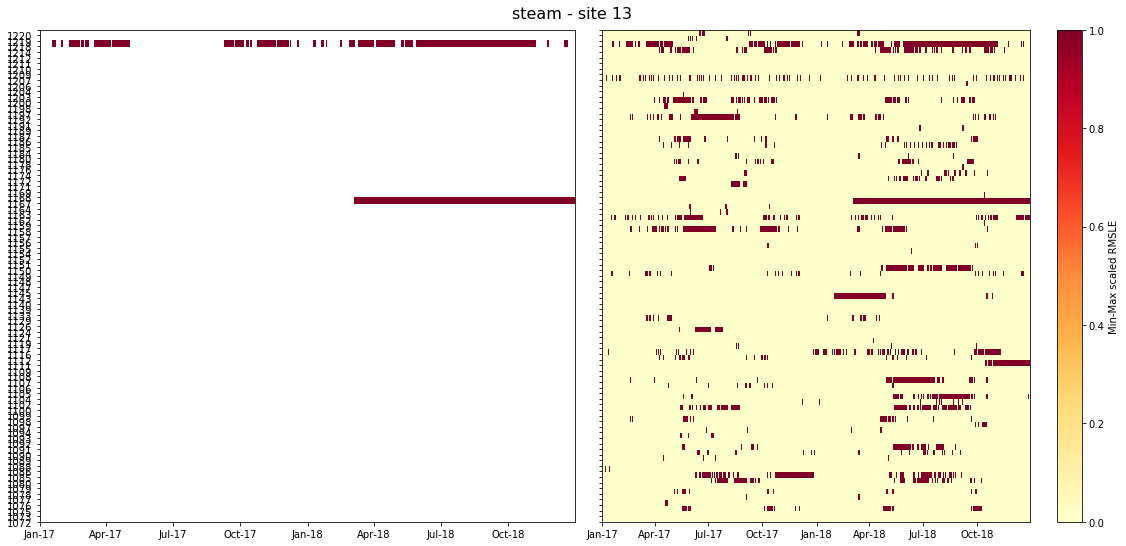

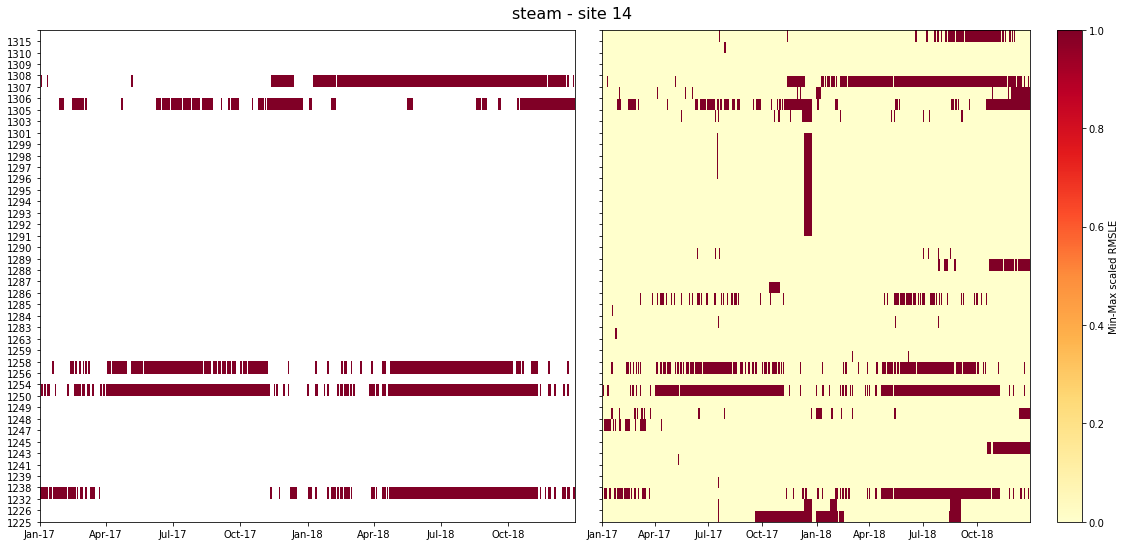

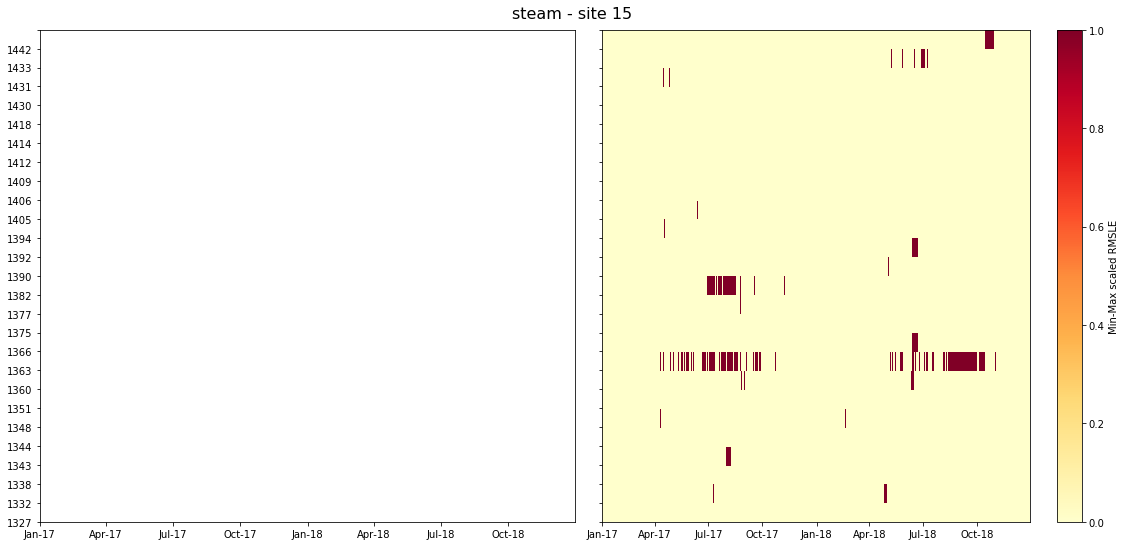

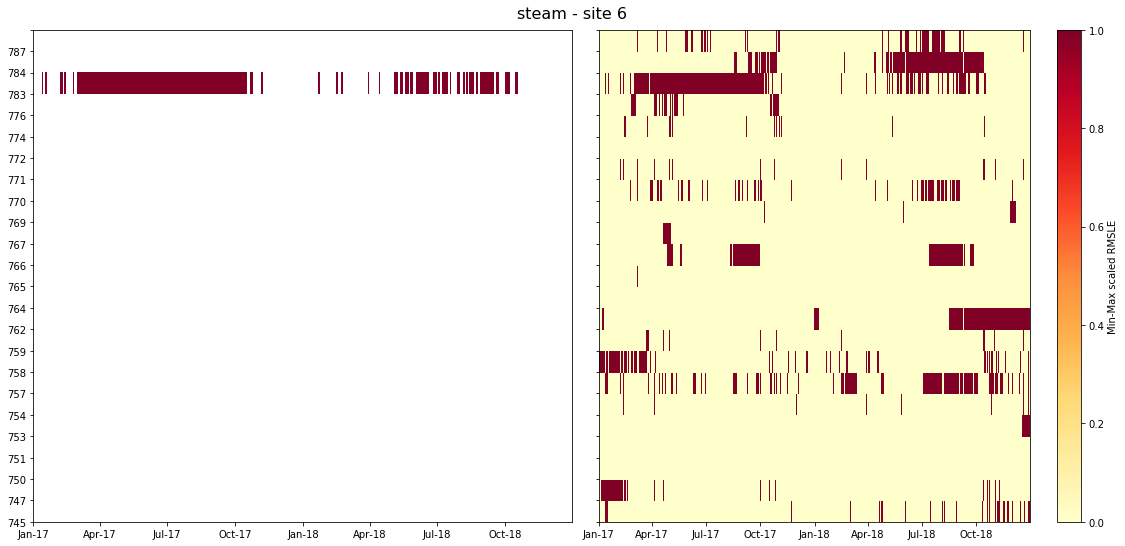

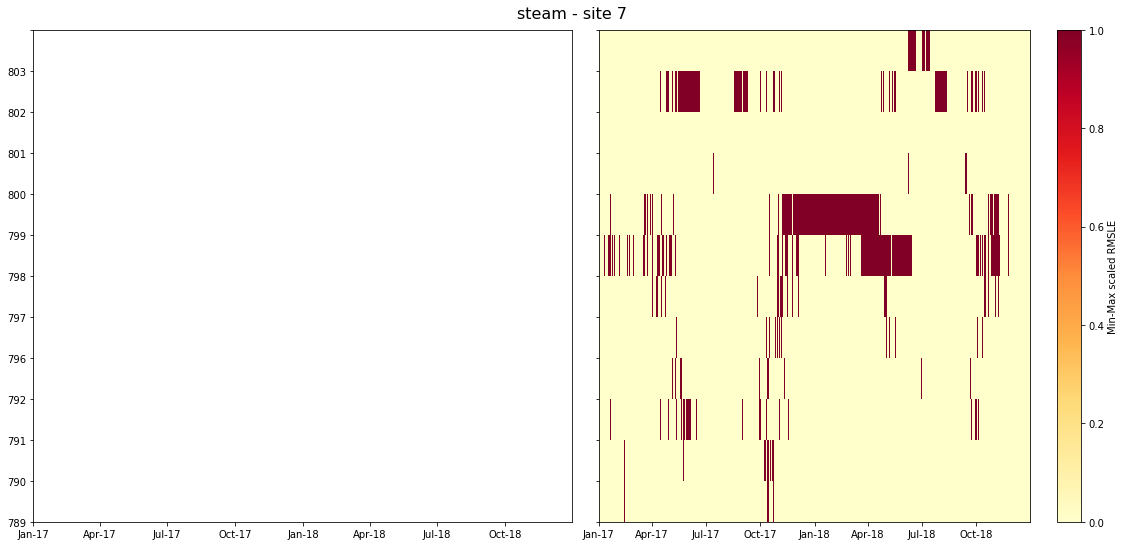

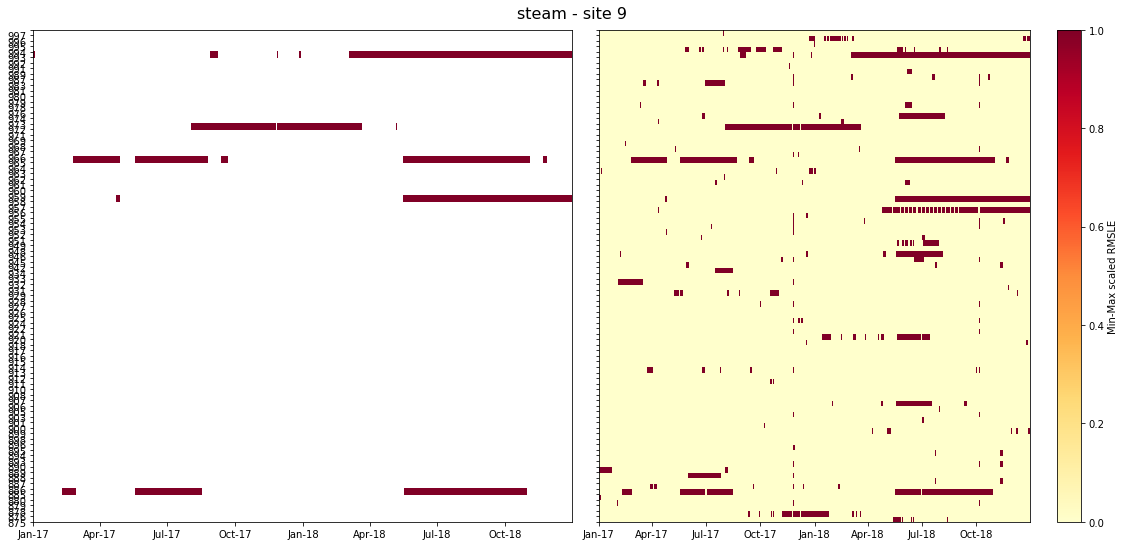

In [17]:
# Function parameters
t_error = 0.3
t_prop = 0.3
error_type = "B"

# Dict to save number of errors
B_errors = {}

for file in files:
    # Create error df for the file
    site, df_B, df_bool = error_B(file ,meter, t_error, t_prop, error_type, True, path_res)

    # Save file
    #df_B.to_csv(path_res + f"{meter}_site_{site}_error{mark}.csv")

    # Count errors by site and append to dict
    B_errors[site] = df_B.T.notna().sum().sum() 

    # Plot
    fig = heatmaps_comp(df_bool,df_B.replace(error_type,1))

# Type C
*Medium-term, single building operational non-routine event*: high errors in a single building, during periods longer than `t_dates`.

steam - site 13
steam - site 14
steam - site 15
steam - site 6
steam - site 7
steam - site 9


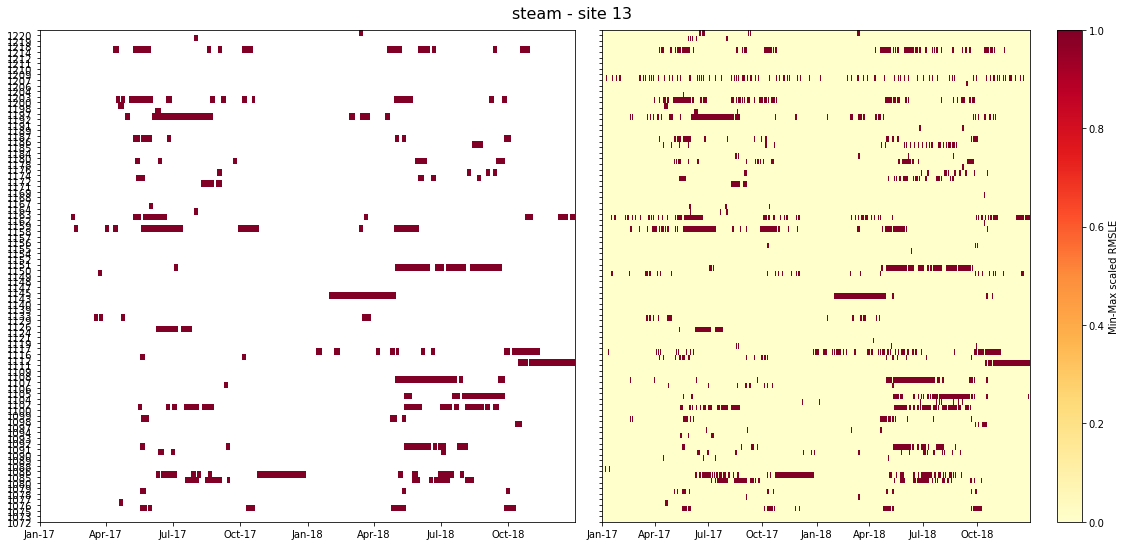

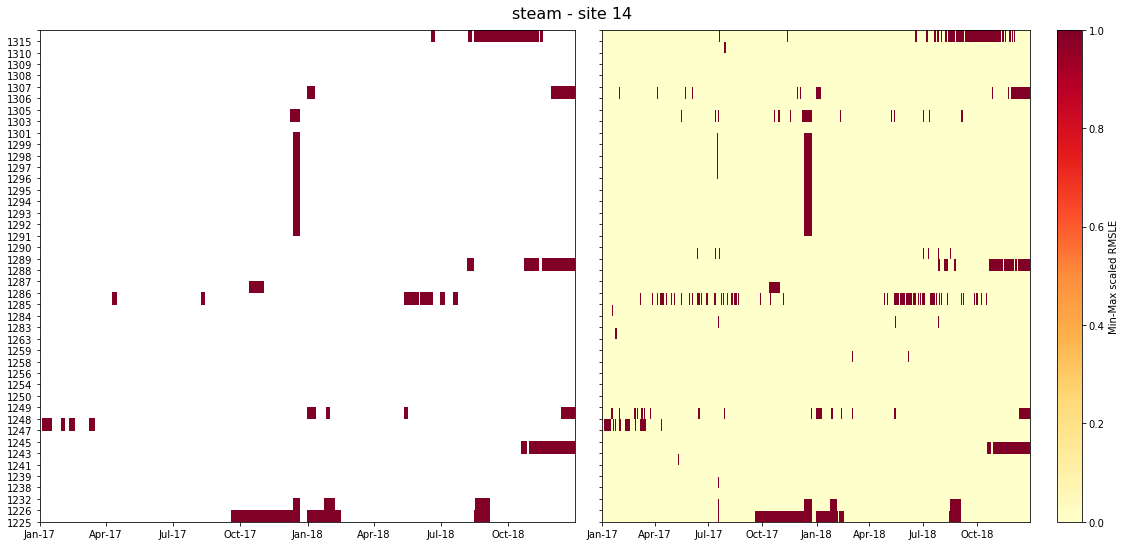

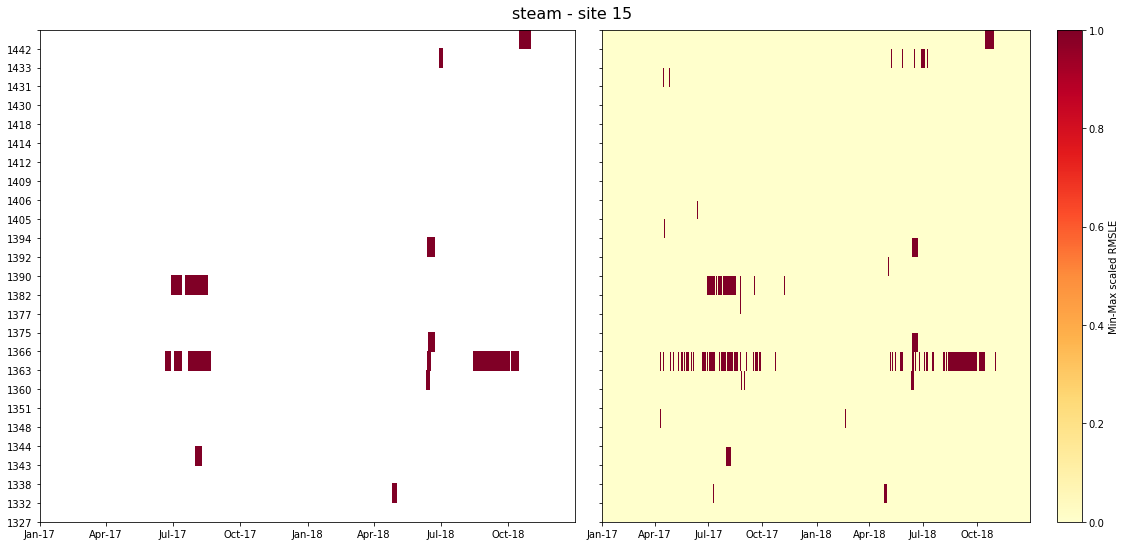

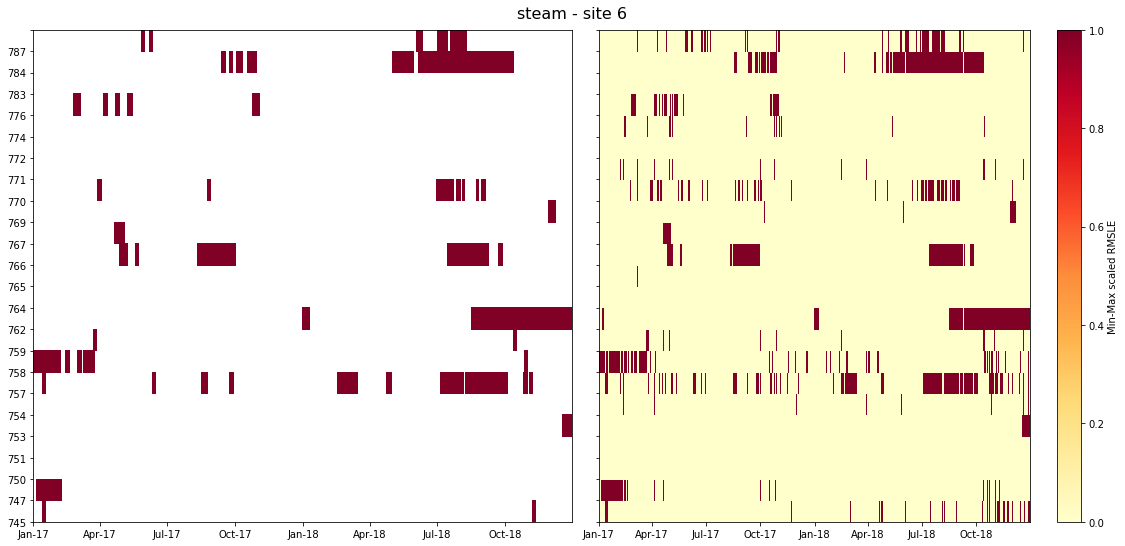

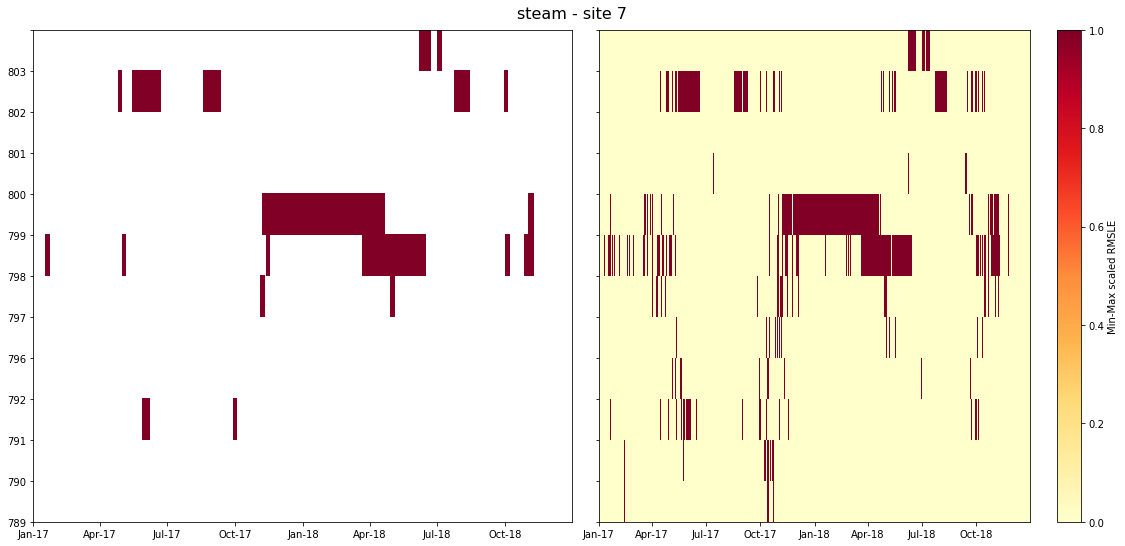

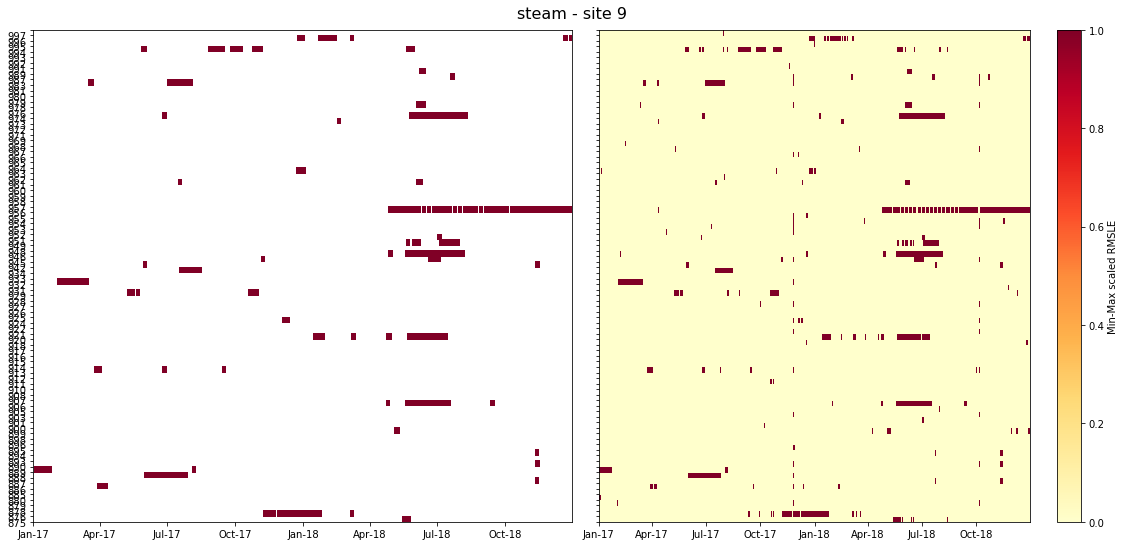

In [19]:
# Function parameters
t_error = 0.3
t_dates = 3
error_type = "C"

# Dict to save number of errors
C_errors = {}

for file in files:
    # Create error df for the file
    site, df_C, df_bool = error_C(file ,meter, t_error, t_dates, error_type, True, path_res)

    # Save file
    #df_C.to_csv(path_res + f"{meter}_site_{site}_error{mark}.csv")

    # Count errors by site and append to dict
    C_errors[site] = df_C.T.notna().sum().sum() 

    # Plot
    fig = heatmaps_comp(df_bool,df_C.replace(error_type,1))

# Type D error
*Short-term, single building non-routine event*: high errors in a single building, during periods shorter than days_threshold.

steam - site 13
steam - site 14
steam - site 15
steam - site 6
steam - site 7
steam - site 9


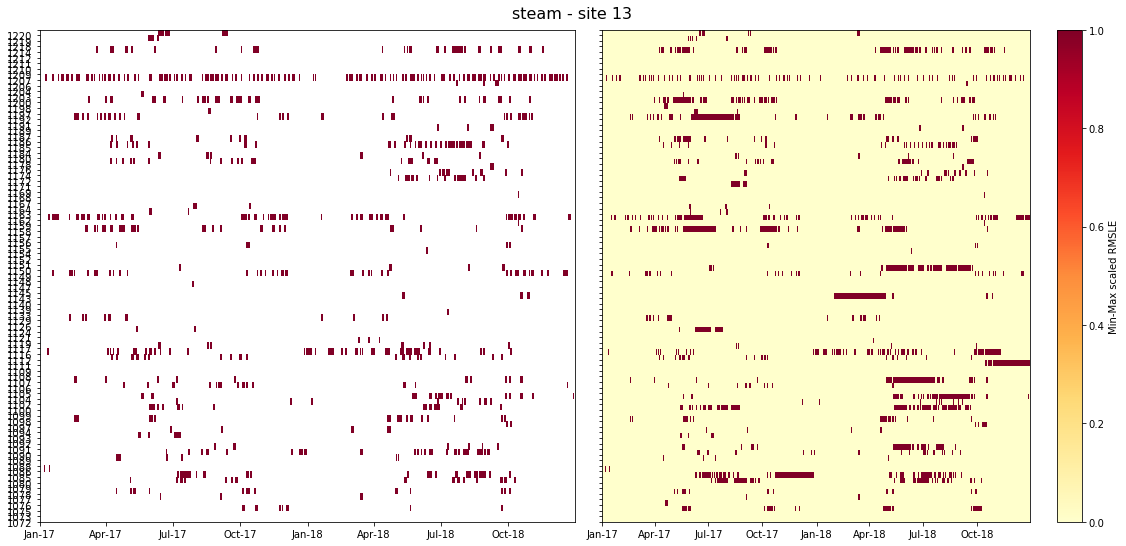

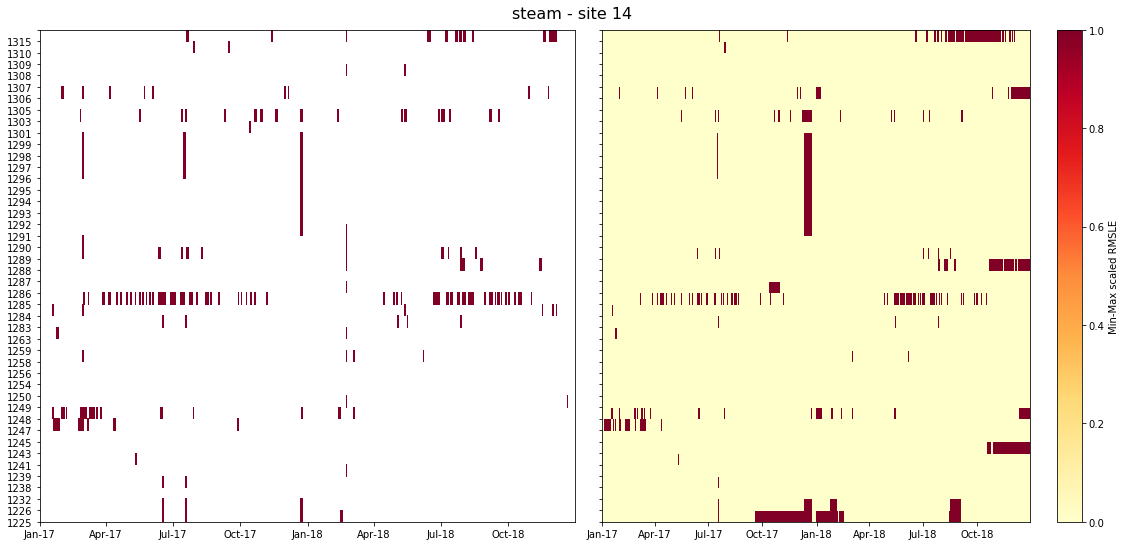

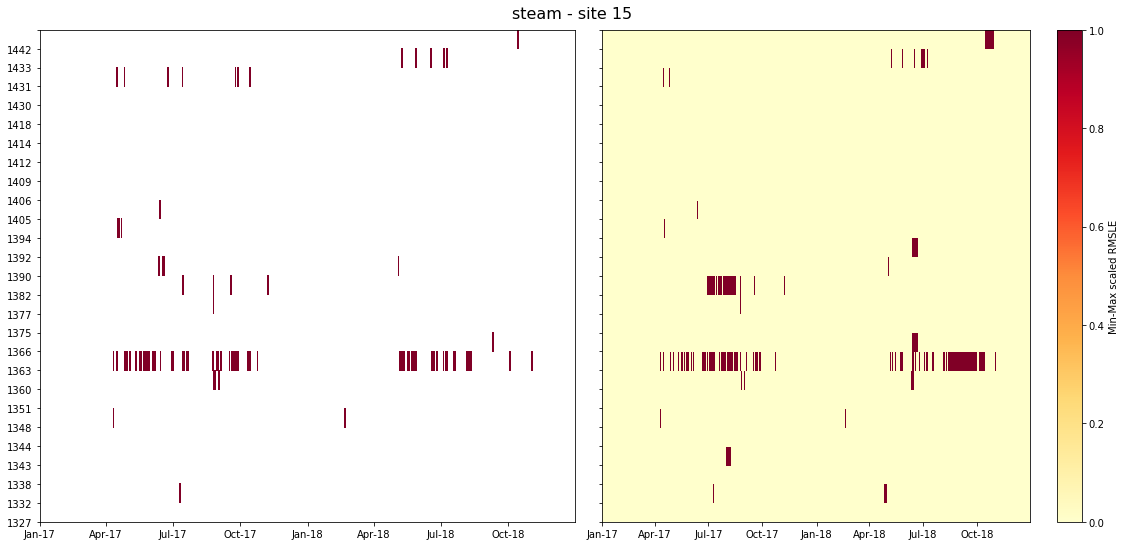

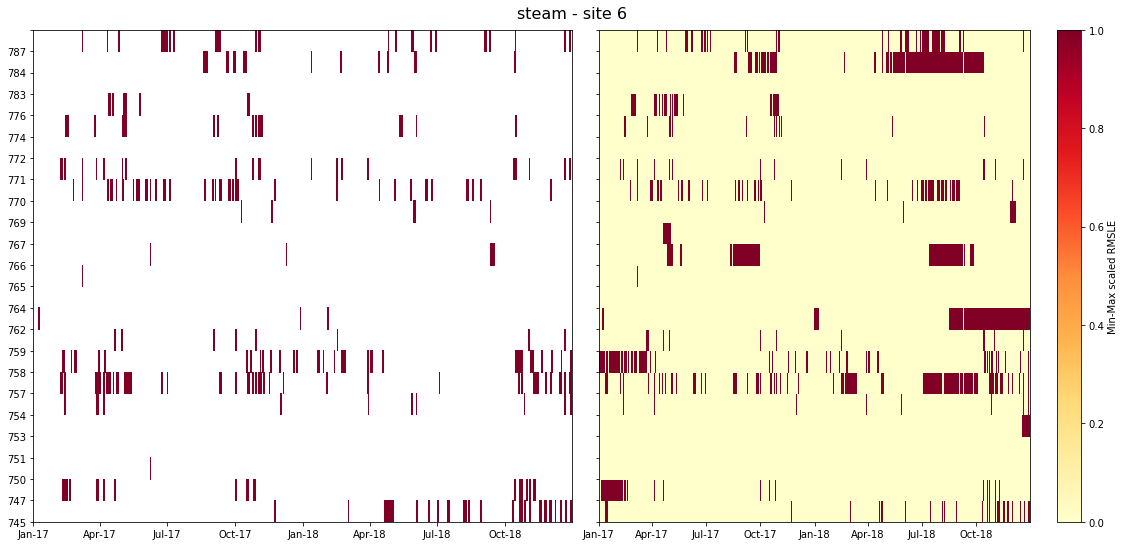

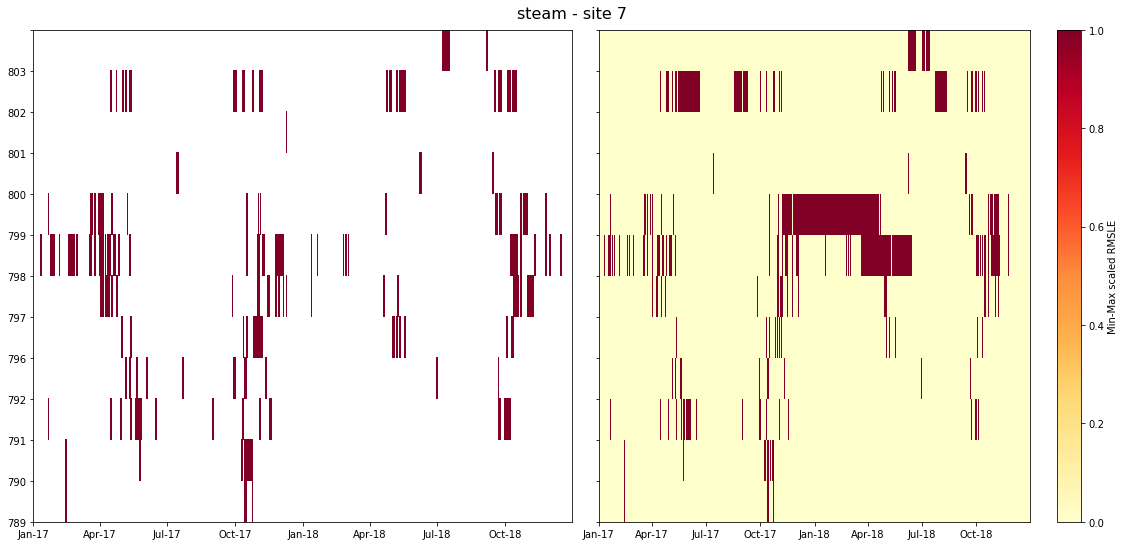

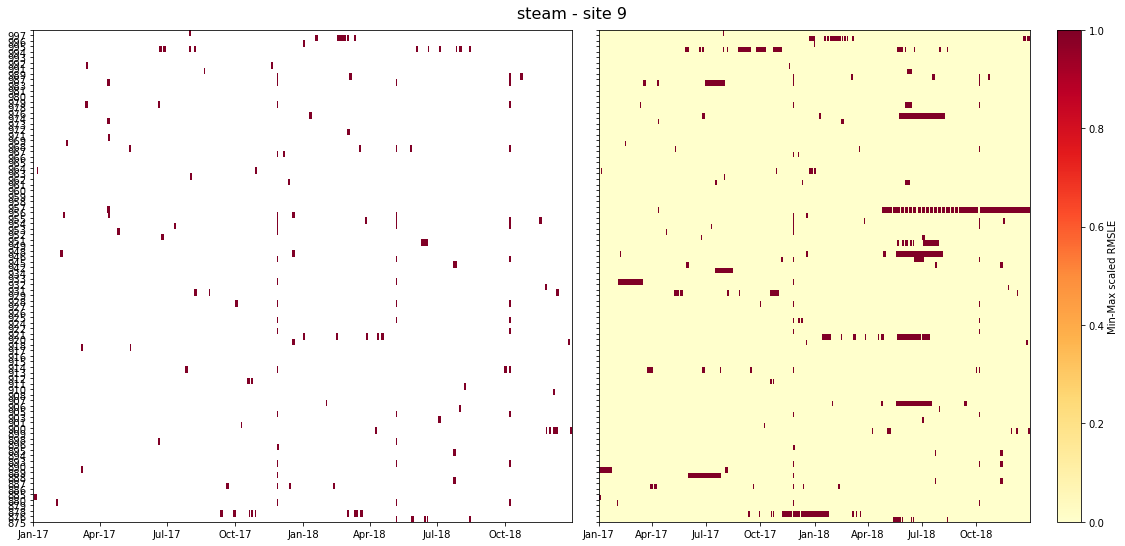

In [20]:
# Function parameters
t_error = 0.3
t_dates = 3
error_type = "D"

# Dict to save number of errors
D_errors = {}

for file in files:
    # Create error df for the file
    site, df_D, df_bool = error_D(file ,meter, t_error, t_dates, error_type, True, path_res)

    # Save file
    #df_D.to_csv(path_res + f"{meter}_site_{site}_error{mark}.csv")

    # Count errors by site and append to dict
    D_errors[site] = df_D.T.notna().sum().sum() 

    # Plot
    fig = heatmaps_comp(df_bool,df_D.replace(error_type,1))

# Type E error (special case of type D errors)
*Fluctuating medium and long term error*: high non-consecutive errors in a single building.

steam - site 13
steam - site 14
steam - site 15
steam - site 6
steam - site 7
steam - site 9


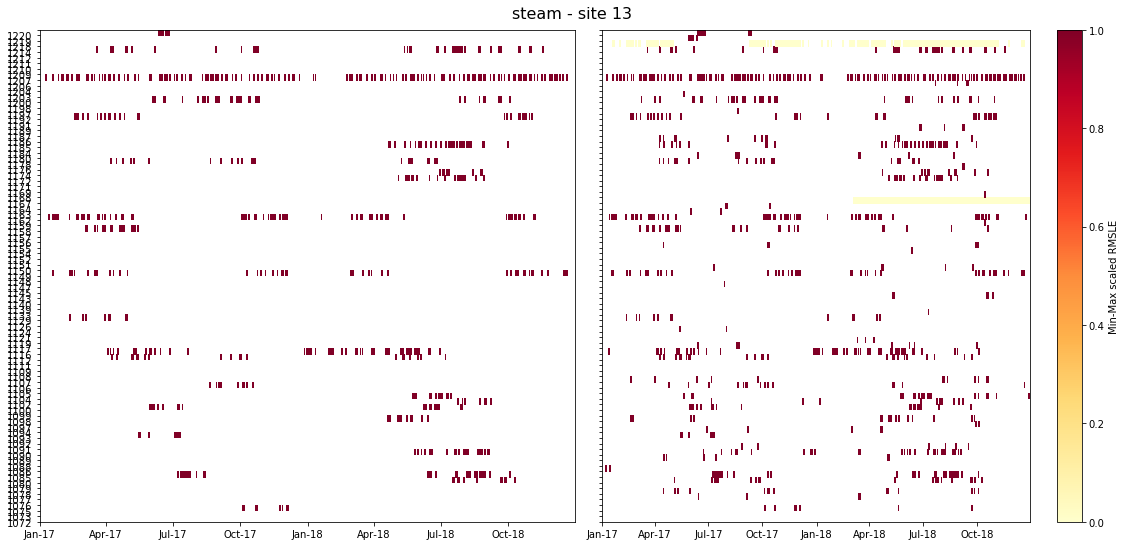

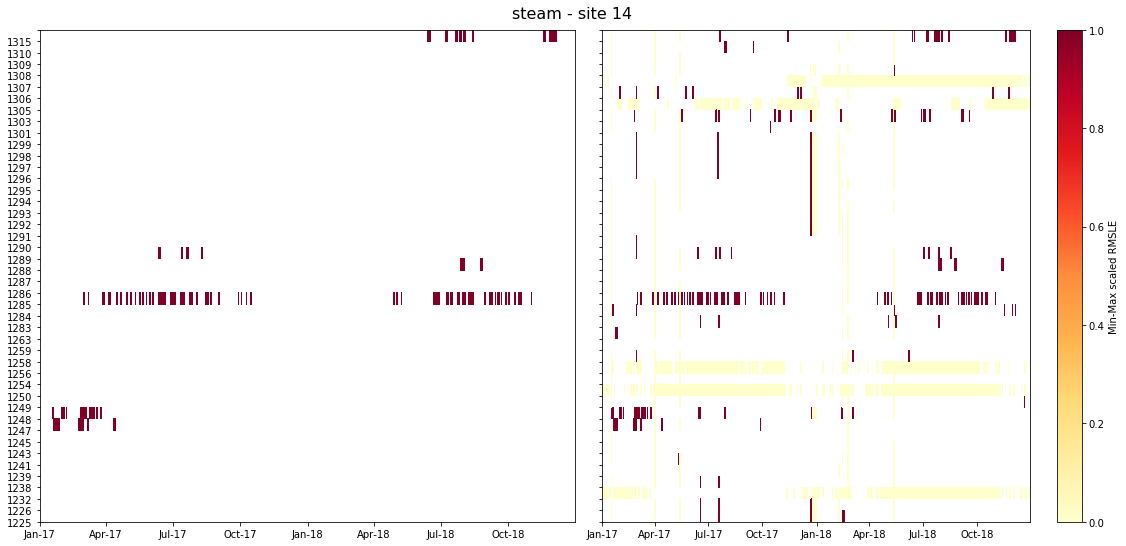

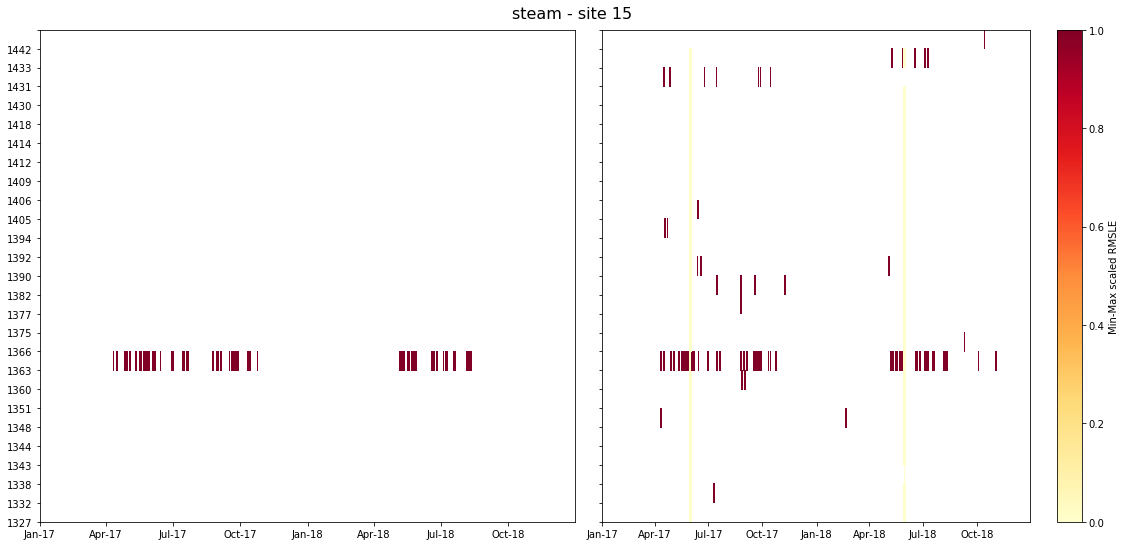

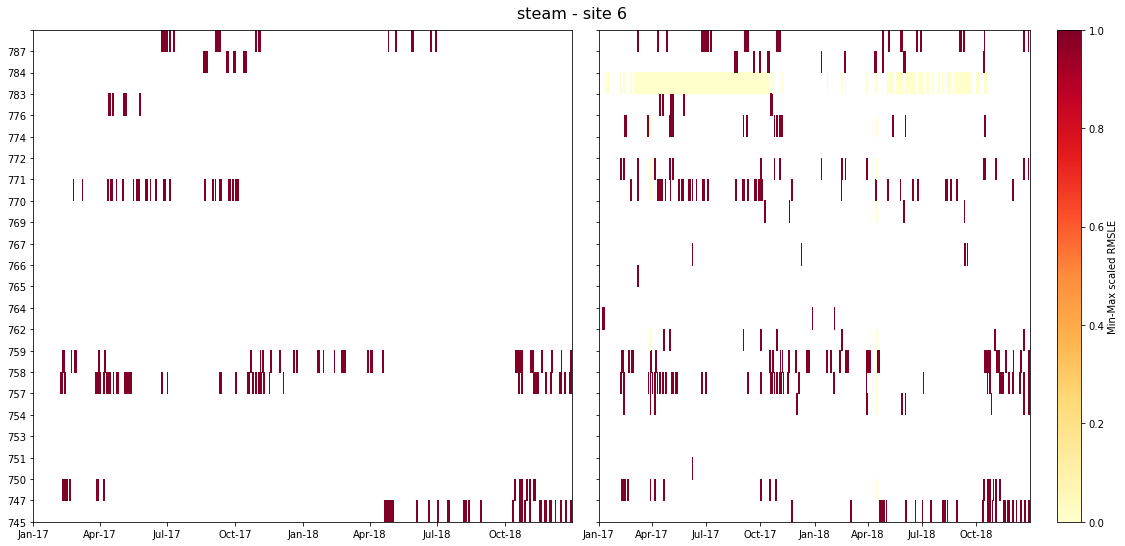

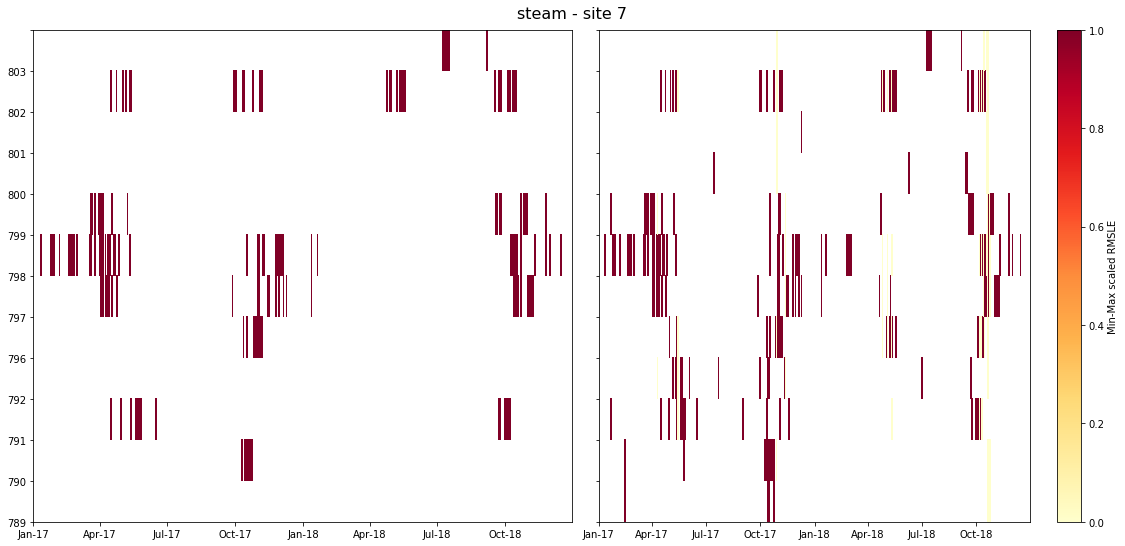

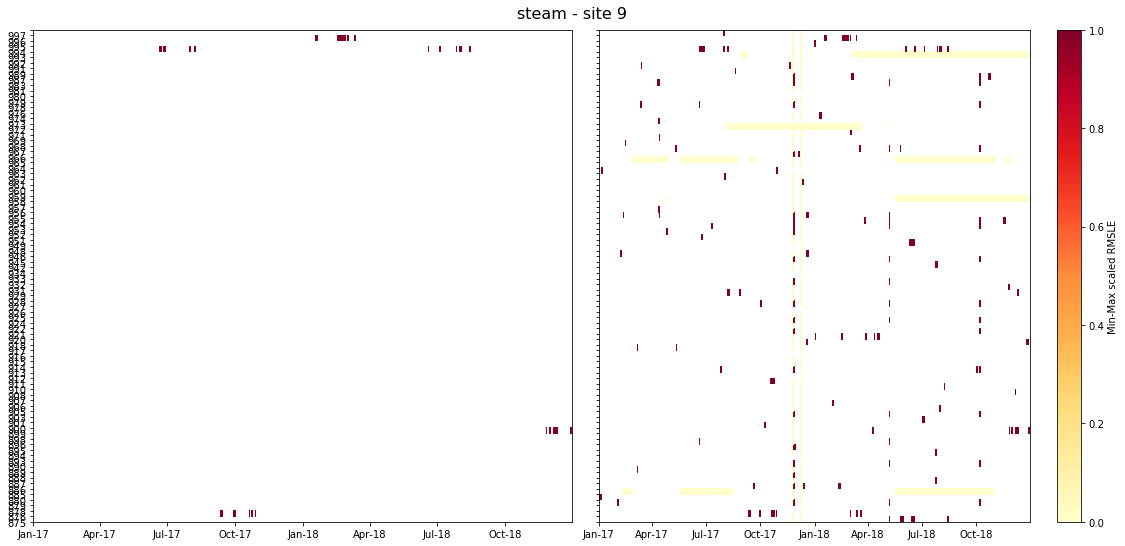

In [21]:
files = glob.glob(path_res + f"{meter}_*_errorD.csv")
# Function parameters
w = 60
t_w = 0.1
error_type = "E"

# Dict to save number of errors
E_errors = {}

for file in files:
    # Create error df for the file
    site, df_E, df_bool = error_E(file ,meter, t_error, t_dates, error_type, True, path_res)

    # Save file
    #df_E.to_csv(path_res + f"{meter}_site_{site}_error{mark}.csv")

    # Count errors by site and append to dict
    E_errors[site] = df_E.T.notna().sum().sum() 

    # Plot
    fig = heatmaps_comp(df_bool,df_E.replace(error_type,1))

# Errors dataframe

In [23]:
# Create dict
all_errors = {"total":total_errors,"A": A_errors,"B":B_errors,"C":C_errors,"D":D_errors,"E":E_errors}
# Convert to df
all_errors_df = pd.DataFrame.from_dict(all_errors).reset_index().rename(columns={"index":"site_id"})
all_errors_df

,site_id,total,A,B,C,D,E
0,13,3628,0,662,1871,1095,776
1,14,3064,332,1729,711,292,152
2,15,460,145,0,204,111,70
3,6,1581,17,307,890,367,233
4,7,742,77,0,417,248,189
5,9,3044,273,1385,1152,234,46


In [24]:
# Check if the sum is correct (E is special cases of D errors, they are not considered)
all_errors_df["check"] = (all_errors_df["total"] == all_errors_df["A"] + all_errors_df["B"] + all_errors_df["C"] + all_errors_df["D"])
all_errors_df

,site_id,total,A,B,C,D,E,check
0,13,3628,0,662,1871,1095,776,True
1,14,3064,332,1729,711,292,152,True
2,15,460,145,0,204,111,70,True
3,6,1581,17,307,890,367,233,True
4,7,742,77,0,417,248,189,True
5,9,3044,273,1385,1152,234,46,True


In [25]:
all_errors_df.drop("check",axis=1,inplace=True)

In [26]:
#all_errors_df.to_csv(path_res + f"{meter}_errors_count.csv", index=False)